## First trial
For the first trial, a reduced part of the dataset will be used (5%)

In [1]:
## import libs
import pandas as pd
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os
import joblib
import matplotlib.pyplot as plt

c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [185]:
## get a reduced slice of the dataset
dataset = pd.read_csv("./datasets/train_processed.csv")
dataset = dataset.sample(frac=0.05, random_state=42)
dataset.to_csv("./datasets/train_reduced.csv", index=False)
dataset["satisfaction"]

dataset_test = pd.read_csv("./datasets/test_processed.csv")
dataset_test = dataset_test.sample(frac=0.05, random_state=42)

dataset_validation = pd.read_csv("./datasets/validation_processed.csv")
dataset_validation = dataset_validation.sample(frac=0.05, random_state=42)


In [186]:
### define the features ###
y_train = dataset["satisfaction"]
X_train = dataset.drop(columns=["satisfaction"])

y_test = dataset_test["satisfaction"]
X_test = dataset_test.drop(columns=["satisfaction"])

y_validation = dataset_validation["satisfaction"]
X_validation = dataset_validation.drop(columns=["satisfaction"])

y_train

55048    2
62524    2
484      1
31026    1
34627    1
        ..
67653    1
65466    1
59585    1
46538    2
20549    2
Name: satisfaction, Length: 3398, dtype: int64

### Hyperparamenters
To optimize the choice process of the hyperparameters, optuna library will be used to create a study case and select the best option to model our MLP with the best values

In [16]:
### use optuna to best tune the hyperparameters ###
def obj_func(trial):
    hidden_layer_sizes = trial.suggest_categorical("hidden_layer_sizes", [1, 2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    activation = trial.suggest_categorical("activation", ["identity", "logistic", "tanh", "relu"])
    solver = trial.suggest_categorical("solver", ["lbfgs", "sgd", "adam"])
    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"])
    alpha = trial.suggest_float("alpha", 0.0001, 0.1)
    max_iter = trial.suggest_int("max_iter", 200, 1000)
    tol = trial.suggest_float("tol", 1e-5, 1e-3)

    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes, 
        activation=activation, 
        solver=solver, 
        learning_rate=learning_rate, 
        alpha=alpha, 
        max_iter=max_iter, 
        tol=tol
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [17]:
study = optuna.create_study(direction="maximize")
study.optimize(obj_func, n_trials=100)

trial = study.best_trial
print("Best trial:")
print("Value: ", trial.value)
print("Params: ")

for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-06-30 15:34:15,049] A new study created in memory with name: no-name-2a08adff-004d-4c16-9b9c-e78b436f20f1
[I 2024-06-30 15:34:17,710] Trial 0 finished with value: 0.8683602771362586 and parameters: {'hidden_layer_sizes': 20, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'adaptive', 'alpha': 0.07703376011478683, 'max_iter': 937, 'tol': 0.0005109601527172201}. Best is trial 0 with value: 0.8683602771362586.
[I 2024-06-30 15:34:36,247] Trial 1 finished with value: 0.8953040800615858 and parameters: {'hidden_layer_sizes': 100, 'activation': 'logistic', 'solver': 'adam', 'learning_rate': 'adaptive', 'alpha': 0.093128146912676, 'max_iter': 456, 'tol': 0.00012853770882294686}. Best is trial 1 with value: 0.8953040800615858.
[I 2024-06-30 15:34:36,896] Trial 2 finished with value: 0.8737490377213241 and parameters: {'hidden_layer_sizes': 10, 'activation': 'logistic', 'solver': 'adam', 'learning_rate': 'constant', 'alpha': 0.09977570485505072, 'max_iter': 220, 'tol': 0.0009595

Best trial:
Value:  0.9268668206312548
Params: 
    hidden_layer_sizes: 90
    activation: tanh
    solver: adam
    learning_rate: constant
    alpha: 0.038443740103269626
    max_iter: 505
    tol: 7.133281723715193e-05


As seen above, the values of the hyperparameters that maximize the accuracy score (92.68%) of the predicted model is:
- hidden layers: 90
- activation: tanh
- solver: adam
- lr: constant
- alpha: 0.03
- max iteractions: 505
- tol: 7.13e-05

### trainning the model
Now it's time to train the reduced model with the defined hyperparameters

In [4]:
### hyperparameters ###
hidden_layer_sizes = (90,)
activation = "tanh"
solver = "adam"
learning_rate = "constant"
alpha = 0.038443740103269626
max_iter = 505
tol = 7.133281723715193e-05

In [5]:
### model ###
from sklearn.metrics import log_loss


model = MLPClassifier(
    hidden_layer_sizes=(10,), 
    activation=activation, 
    solver=solver, 
    learning_rate=learning_rate, 
    alpha=alpha, 
    max_iter=max_iter, 
    tol=tol,
)

loss = []
validation_loss = []

for i in range(100):
    model.fit(X_train, y_train)
    loss.append(model.loss_)

    y_val_preds = model.predict_proba(X_validation)
    validation_loss_epoch = log_loss(y_validation, y_val_preds)
    validation_loss.append(validation_loss_epoch)

    if i % 10 == 0:
        print(f"Epoch {i} - Loss: {model.loss_} - Validation loss: {validation_loss_epoch} - Accuracy: {model.score(X_train, y_train)}")

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print("Confusion matrix: ")
print(confusion_matrix(y_test, y_pred))

print("Classification report: ")
print(classification_report(y_test, y_pred))

c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 0 - Loss: 0.13849942630179599 - Validation loss: 0.23275030480571618 - Accuracy: 0.9508534432018835


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 10 - Loss: 0.14522805907505212 - Validation loss: 0.21947128894023915 - Accuracy: 0.948204826368452


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 20 - Loss: 0.1464733940458414 - Validation loss: 0.22839568368563556 - Accuracy: 0.9473219540906416


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 30 - Loss: 0.13835794264334672 - Validation loss: 0.22130892371429584 - Accuracy: 0.9523248969982343


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 40 - Loss: 0.15689684571954485 - Validation loss: 0.23725705535535555 - Accuracy: 0.9367274867569159


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 50 - Loss: 0.13713145560249015 - Validation loss: 0.2343821337827701 - Accuracy: 0.9529134785167745


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 60 - Loss: 0.1498032811547135 - Validation loss: 0.22966255286899875 - Accuracy: 0.9467333725721012


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 70 - Loss: 0.14184341673110148 - Validation loss: 0.20989669837977212 - Accuracy: 0.9523248969982343


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 80 - Loss: 0.14944161511884105 - Validation loss: 0.2314914822215015 - Accuracy: 0.9476162448499117


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 90 - Loss: 0.14202289559881895 - Validation loss: 0.21059505934737252 - Accuracy: 0.9511477339611536


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9006928406466512
Confusion matrix: 
[[678  71]
 [ 58 492]]
Classification report: 
              precision    recall  f1-score   support

           1       0.92      0.91      0.91       749
           2       0.87      0.89      0.88       550

    accuracy                           0.90      1299
   macro avg       0.90      0.90      0.90      1299
weighted avg       0.90      0.90      0.90      1299



c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


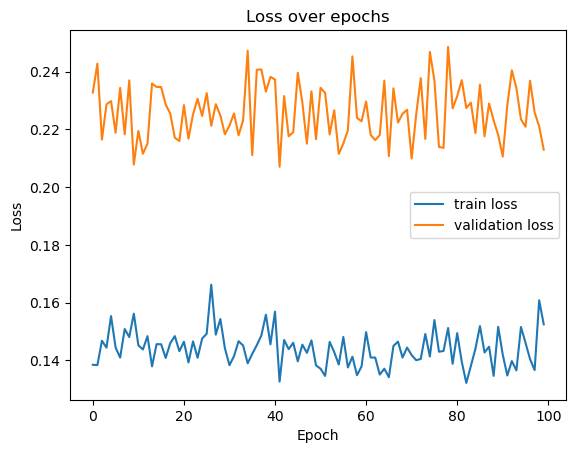

In [6]:
plt.figure()
plt.plot(range(len(loss)), loss, label="train loss")
plt.plot(range(len(loss)), validation_loss, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.legend()
plt.show()

As the loss is not validation loss isn't following the training loss, let us go to build another model

## Trial 2
Trying more than 1 layer

In [155]:
### import libs ###
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, classification_report
import joblib

### Object function
Below a objective funtion will be responsible for selecting the best hyperparameters

In [99]:
def objective(trial):
    hidden_layer_sizes = tuple([trial.suggest_int("n_units_l{}".format(i), 10, 100) for i in range(trial.suggest_int("n_layers", 1, 3))])
    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])

    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
         activation=activation, 
         solver=solver,
        alpha=alpha, 
        learning_rate=learning_rate, 
        max_iter=1000, 
        random_state=42
    )

    mlp.fit(X_train, y_train)
    
    # predicting to validation data
    y_pred = mlp.predict(X_validation)
    accuracy = accuracy_score(y_validation, y_pred)
    
    return accuracy


# creating a study case for the hp
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# best hp results
print("Best HP: ", study.best_params)

[I 2024-06-30 18:23:31,727] A new study created in memory with name: no-name-bcb5b9aa-ede4-4388-b0ab-6d2113948320
C:\Users\mpps\AppData\Local\Temp\ipykernel_24364\2331679104.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2)
[I 2024-06-30 18:23:32,450] Trial 0 finished with value: 0.5702373316228352 and parameters: {'n_layers': 3, 'n_units_l0': 58, 'n_units_l1': 72, 'n_units_l2': 95, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0013945937767777547, 'learning_rate': 'invscaling'}. Best is trial 0 with value: 0.5702373316228352.
C:\Users\mpps\AppData\Local\Temp\ipykernel_24364\2331679104.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Melhores hiperparâmetros:  {'n_layers': 2, 'n_units_l0': 81, 'n_units_l1': 13, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 3.413030580713089e-05, 'learning_rate': 'constant'}


### Modeling and training
Now we'll build the model with the best hp and train our model. Also, we'll watch the loss beahavior

In [176]:
best_params = study.best_params
hidden_layer_sizes = tuple([best_params["n_units_l{}".format(i)] for i in range(best_params["n_layers"])])

mlp = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes, 
    activation=best_params['activation'], 
    solver=best_params['solver'],
    alpha=best_params['alpha'], 
    learning_rate=best_params['learning_rate'], 
    max_iter=1000, 
    random_state=42
)

train_loss = []
validation_loss = []

mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))

patience = 10
best_loss = np.inf
best_epoch = 0

for i in range(1000):
    mlp.partial_fit(X_train, y_train)
    train_loss.append(mlp.loss_)
    
    y_val_preds = mlp.predict_proba(X_validation)
    validation_loss_epoch = log_loss(y_validation, y_val_preds)
    validation_loss.append(validation_loss_epoch)

    if validation_loss_epoch < best_loss:
        best_loss = validation_loss_epoch
        best_epoch = i
    
    elif i - best_epoch > patience:
        print(f"Early stopping at epoch {i}")
        break
    
    if i % 10 == 0:
        print(f"Epoch {i} - Loss: {mlp.loss_} - Validation loss: {validation_loss_epoch} - Accuracy: {mlp.score(X_train, y_train)}")


Epoch 0 - Loss: 0.6337141648317964 - Validation loss: 0.6056217401205681 - Accuracy: 0.7060035314891112
Epoch 10 - Loss: 0.4133915176666137 - Validation loss: 0.41430095381613286 - Accuracy: 0.8478516774573278
Epoch 20 - Loss: 0.35126286161424525 - Validation loss: 0.3548134043198413 - Accuracy: 0.8640376692171866
Epoch 30 - Loss: 0.3231283990430614 - Validation loss: 0.3284885314378939 - Accuracy: 0.8716892289582107
Epoch 40 - Loss: 0.30715629270571243 - Validation loss: 0.31361244303794983 - Accuracy: 0.8766921718658034
Epoch 50 - Loss: 0.2959797216550352 - Validation loss: 0.30321445190392615 - Accuracy: 0.8787522071806946
Epoch 60 - Loss: 0.2870751422837899 - Validation loss: 0.2950115245843961 - Accuracy: 0.8816951147733961
Epoch 70 - Loss: 0.27948388398749585 - Validation loss: 0.28812827422253723 - Accuracy: 0.8843437316068276
Epoch 80 - Loss: 0.2728007897100851 - Validation loss: 0.28214113789456646 - Accuracy: 0.8861094761624485
Epoch 90 - Loss: 0.26679346685444744 - Validatio

In [177]:
y_pred = mlp.predict(X_test)

# evaluating the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### save the model ###
joblib.dump(mlp, "./models/mlp_trial2.pkl")

[[675  74]
 [ 51 499]]
              precision    recall  f1-score   support

           1       0.93      0.90      0.92       749
           2       0.87      0.91      0.89       550

    accuracy                           0.90      1299
   macro avg       0.90      0.90      0.90      1299
weighted avg       0.90      0.90      0.90      1299



['./models/mlp_trial2.pkl']

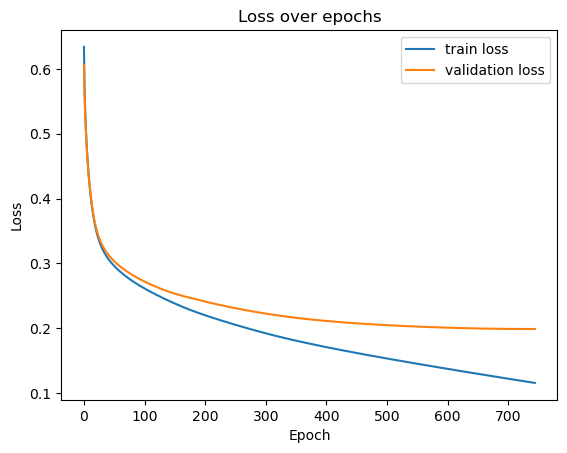

In [178]:
plt.figure()
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(train_loss)), validation_loss, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.legend()
plt.show()

As the result above was satisfactive, let's run an oficial test!

## Oficial trial
All dataset.
Since it's size, creating checkpoints will be necessary

In [219]:
### import libs ###
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_classification
import seaborn as sns

In [189]:
dataset_train = pd.read_csv("./datasets/train_processed.csv")
dataset_test = pd.read_csv("./datasets/test_processed.csv")
dataset_validation = pd.read_csv("./datasets/validation_processed.csv")

y_train = dataset_train["satisfaction"]
X_train = dataset_train.drop(columns=["satisfaction"])

y_test = dataset_test["satisfaction"]
X_test = dataset_test.drop(columns=["satisfaction"])

y_validation = dataset_validation["satisfaction"]
X_validation = dataset_validation.drop(columns=["satisfaction"])

y_train

0        1
1        1
2        2
3        1
4        2
        ..
67963    1
67964    2
67965    1
67966    1
67967    1
Name: satisfaction, Length: 67968, dtype: int64

In [190]:
best_params = study.best_params
hidden_layer_sizes = tuple([best_params["n_units_l{}".format(i)] for i in range(best_params["n_layers"])])

mlp = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes, 
    activation=best_params['activation'], 
    solver=best_params['solver'],
    alpha=best_params['alpha'], 
    learning_rate=best_params['learning_rate'], 
    max_iter=1000, 
    random_state=42
)

train_loss = []
validation_loss = []
acc_over_epochs = []

mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))

patience = 10
best_loss = np.inf
best_epoch = 0

for i in range(1000):
    mlp.partial_fit(X_train, y_train)
    train_loss.append(mlp.loss_)
    
    y_val_preds = mlp.predict_proba(X_validation)
    validation_loss_epoch = log_loss(y_validation, y_val_preds)
    validation_loss.append(validation_loss_epoch)

    accuracy = accuracy_score(y_validation, mlp.predict(X_validation))
    acc_over_epochs.append(accuracy)

    if validation_loss_epoch < best_loss:
        best_loss = validation_loss_epoch
        best_epoch = i
    
    elif i - best_epoch > patience:
        print(f"Early stopping at epoch {i}")
        break
    
    if i % 10 == 0:
        print(f"Epoch {i} - Loss: {mlp.loss_} - Validation loss: {validation_loss_epoch} - Accuracy: {mlp.score(X_train, y_train)}")
    
    if i % 100 == 0:
        joblib.dump(mlp, f"./models/oficial_trial/mlp_partial_{i}.pkl")


Epoch 0 - Loss: 0.3360217151943596 - Validation loss: 0.31787749388901704 - Accuracy: 0.8666137005649718
Epoch 10 - Loss: 0.23581616830035454 - Validation loss: 0.2326416293804857 - Accuracy: 0.9034251412429378
Epoch 20 - Loss: 0.2101623412507603 - Validation loss: 0.2064935460453953 - Accuracy: 0.9165489642184558
Epoch 30 - Loss: 0.19490445237116838 - Validation loss: 0.1918160180173069 - Accuracy: 0.9244644538606404
Epoch 40 - Loss: 0.18417925542421001 - Validation loss: 0.1820315353606215 - Accuracy: 0.9291578389830508
Epoch 50 - Loss: 0.17590346938294302 - Validation loss: 0.17440652235288776 - Accuracy: 0.9323505178907722
Epoch 60 - Loss: 0.16910051112626803 - Validation loss: 0.1680799918100076 - Accuracy: 0.9344838747645952
Epoch 70 - Loss: 0.16337144214758403 - Validation loss: 0.16281230257966495 - Accuracy: 0.9361905602636534
Epoch 80 - Loss: 0.1585773341321592 - Validation loss: 0.1584444881342878 - Accuracy: 0.937455861581921
Epoch 90 - Loss: 0.15454964052442807 - Validatio

In [191]:
y_pred = mlp.predict(X_test)

# evaluating the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### save the model ###
joblib.dump(mlp, "./models/oficial_trial/mlp_oficial.pkl")

[[14178   395]
 [  906 10497]]
              precision    recall  f1-score   support

           1       0.94      0.97      0.96     14573
           2       0.96      0.92      0.94     11403

    accuracy                           0.95     25976
   macro avg       0.95      0.95      0.95     25976
weighted avg       0.95      0.95      0.95     25976



['./models/oficial_trial/mlp_oficial.pkl']

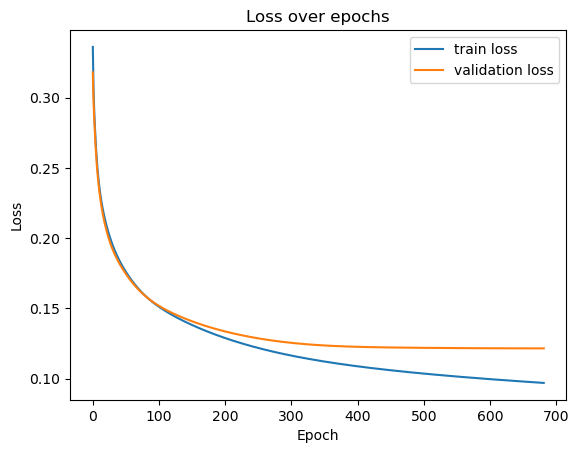

In [192]:
plt.figure()
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(train_loss)), validation_loss, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.legend()
plt.show()

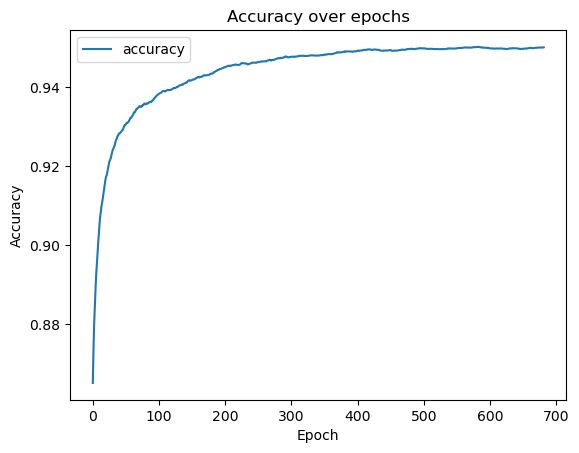

In [193]:
plt.figure()
plt.plot(range(len(acc_over_epochs)), acc_over_epochs, label="accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.legend()
plt.show()

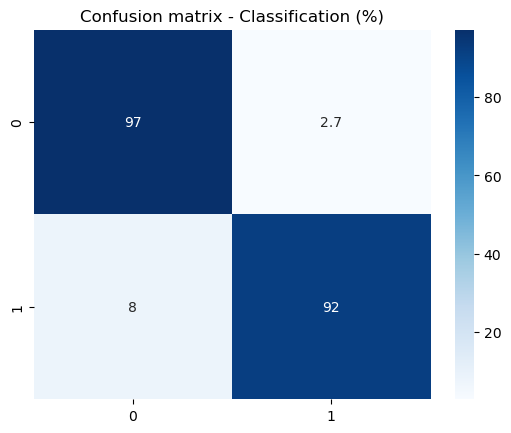

In [223]:
### plot confusion matrix ###
cf = confusion_matrix(y_test, y_pred)
cf = pd.DataFrame(cf, columns=["0", "1"], index=["0", "1"])

percentage_cf = cf.div(cf.sum(axis=1), axis=0) * 100
percentage_cf = percentage_cf.round(2)

plt.figure()
sns.heatmap(percentage_cf, annot=True, cmap="Blues")
plt.title("Confusion matrix - Classification (%)")
plt.show()

In [224]:
### table of classification report ###
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
1,0.939936,0.972895,0.956132,14573.000000
2,0.963735,0.920547,0.941646,11403.000000
accuracy,0.949915,0.949915,0.949915,0.949915
macro avg,0.951836,0.946721,0.948889,25976.000000
weighted avg,0.950383,0.949915,0.949773,25976.000000
